# Классификация клиентов телеком компании

В моем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф.

Необходимо построить модель с максимально большим значением *accuracy*. 

Описание данных

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Откроем и изучим файл

In [84]:
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [85]:
df = pd.read_csv('/datasets/users_behavior.csv')

In [86]:
df

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [88]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [89]:
df.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


In [90]:
df['is_ultra'].unique()

array([0, 1])

In [91]:
len(df.query('is_ultra == 0'))

2229

In [92]:
len(df.query('is_ultra == 1'))

985

Вывод: 

Датасет содержит следующие стоблцы:
- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Разобьем данные на выборки

In [93]:
features = df.drop('is_ultra', axis=1)
target = df['is_ultra']

In [94]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, 
    target, 
    test_size=0.2, 
    random_state=12345, 
    stratify=target)

In [95]:
features_train, features_test, target_train, target_test = train_test_split(
    features_train, 
    target_train,  
    test_size=0.25, 
    random_state=12345,
    stratify=target_train)

In [96]:
features_train

,calls,minutes,messages,mb_used
1659,27.0,170.58,23.0,21798.61
2176,75.0,489.47,7.0,20478.94
108,47.0,300.12,123.0,31244.61
426,36.0,198.96,32.0,21596.86
1892,102.0,740.28,19.0,17864.12
...,...,...,...,...
2298,64.0,475.68,20.0,8540.27
397,80.0,547.01,54.0,21265.57
1439,38.0,275.74,16.0,7122.54
3151,84.0,622.60,32.0,16318.74


In [97]:
features_valid

,calls,minutes,messages,mb_used
2424,56.0,364.36,0.0,14129.94
2118,76.0,430.70,34.0,25138.49
2034,108.0,812.04,4.0,24490.28
2286,67.0,460.76,27.0,16626.26
1364,69.0,515.52,34.0,21231.90
...,...,...,...,...
2295,10.0,61.30,0.0,958.19
2327,58.0,370.03,29.0,33526.69
1983,44.0,293.54,51.0,11816.92
2315,48.0,341.65,0.0,19000.02


In [98]:
features_test

,calls,minutes,messages,mb_used
580,43.0,321.63,42.0,25599.87
2272,93.0,658.89,38.0,17655.47
1415,82.0,507.89,88.0,17543.37
1356,43.0,256.90,1.0,10450.48
1910,111.0,728.20,37.0,14135.23
...,...,...,...,...
3133,56.0,385.68,28.0,18148.98
2268,10.0,78.67,8.0,4986.91
49,58.0,474.92,11.0,17858.59
1980,47.0,367.09,42.0,22329.28


Вывод:

Исходные данные были разделены на обучающую, валидационную и тестовую выборки в отношении 3:1:1. Модель будет обучаться на обучающей выборке, качество модели будет оцениваться по валидационной и тестовой выборке.

## Исследуем модели

In [99]:
depth_mass = []
acc_valid_mass = []
acc_train_mass = []
for depth in range(1,21):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    accuracy = accuracy_score(target_valid, predictions_valid)
    depth_mass.append(depth)
    acc_valid_mass.append(accuracy)
    acc_train_mass.append(accuracy_score(target_train, model.predict(features_train)))
    print('max_depth = {0} : {1}'.format(depth, accuracy))

max_depth = 1 : 0.7480559875583204
max_depth = 2 : 0.7853810264385692
max_depth = 3 : 0.7993779160186625
max_depth = 4 : 0.7838258164852255
max_depth = 5 : 0.7962674961119751
max_depth = 6 : 0.7978227060653188
max_depth = 7 : 0.7822706065318819
max_depth = 8 : 0.7791601866251944
max_depth = 9 : 0.7822706065318819
max_depth = 10 : 0.7822706065318819
max_depth = 11 : 0.7791601866251944
max_depth = 12 : 0.7682737169517885
max_depth = 13 : 0.7542768273716952
max_depth = 14 : 0.7433903576982893
max_depth = 15 : 0.7293934681181959
max_depth = 16 : 0.7091757387247278
max_depth = 17 : 0.71850699844479
max_depth = 18 : 0.7231726283048211
max_depth = 19 : 0.7262830482115086
max_depth = 20 : 0.71850699844479


График изменения качества модели в зависимости от глубины представлен ниже для обучающей выборки и для валидационной выборки. Оптимальное значение качества наблюдается для модели с глубиной равной 3.

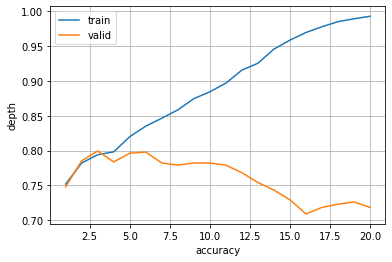

In [100]:
plt.plot(depth_mass, acc_train_mass);
plt.plot(depth_mass, acc_valid_mass);
plt.grid(True);
plt.xlabel('accuracy');
plt.ylabel('depth');
plt.legend(['train', 'valid']);

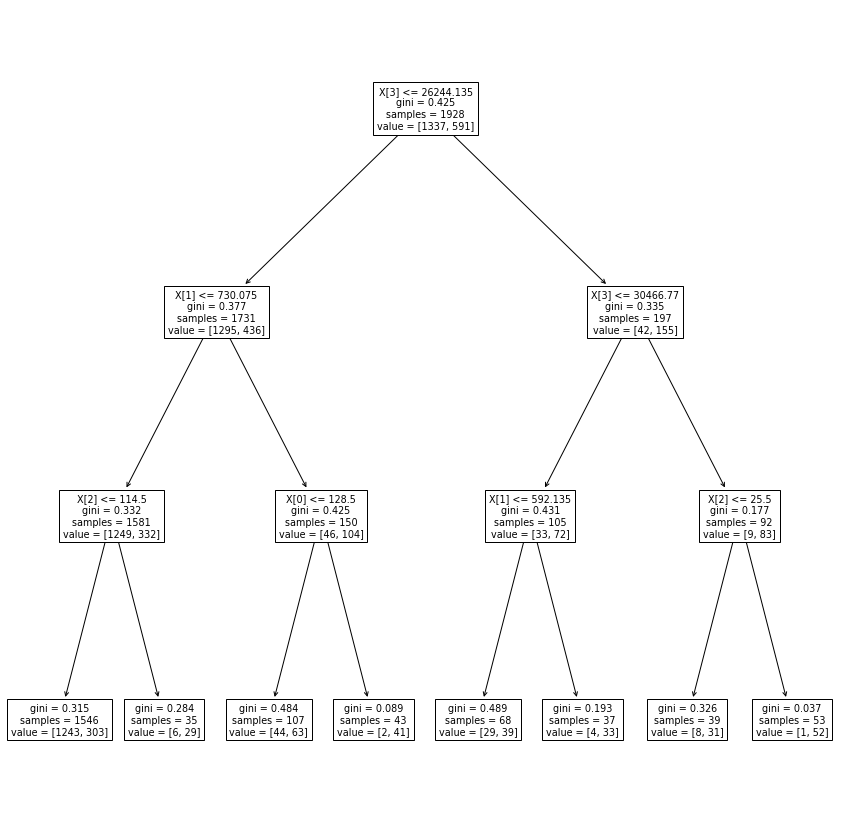

In [101]:
model = DecisionTreeClassifier(random_state=12345, max_depth=3)
model.fit(features_train, target_train)
plt.figure(figsize=[15,15]);
tree.plot_tree(model);

In [102]:
best_res = 0
for est in range(1, 31):
    for depth in range(1,6):    
        model = RandomForestClassifier(
            random_state=12345, 
            n_estimators=est,
            max_depth=depth) 
        model.fit(features_train,target_train)
        predictions_valid = model.predict(features_valid)
        accuracy = accuracy_score(target_valid, predictions_valid)
        if accuracy > best_res:
            best_res = accuracy
            est_best = est
            depth_best = depth       
'n_est = {0}, depth = {1} : {2}'.format(est_best, depth_best, best_res)

'n_est = 17, depth = 5 : 0.8133748055987559'

In [103]:
model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000) 
model.fit(features_train,target_train)
predictions_valid = model.predict(features_valid)
accuracy = accuracy_score(target_valid, predictions_valid)
accuracy

0.7371695178849145

Вывод:

Были сравнены три модели: решающее дерево, случайный лес и логистическая регрессия. Для модели решающего дерева были рассмотрены различные значения гиперпараметра - глубина. Для модели случайного леса были рассмотрееы различные значения гиперпараметров - количество деревьев и глубина. Самое высокое качество у случайного леса при глубине 5 и количестве деревьев 17: 0.8133748055987559.

## Проверьте модель на тестовой выборке

In [116]:
model = RandomForestClassifier(
            random_state=12345, 
            n_estimators=17,
            max_depth=5) 
model.fit(features_train, target_train)
predictions_test = model.predict(features_test)
accuracy = accuracy_score(target_test, predictions_test)
accuracy

0.8180404354587869

In [105]:
sklearn.metrics.confusion_matrix(target_test, predictions_test)

array([[417,  29],
       [ 88, 109]])

In [106]:
sklearn.metrics.precision_score(target_test, predictions_test, pos_label=0)

0.8257425742574257

In [107]:
sklearn.metrics.precision_score(target_test, predictions_test, pos_label=1)

0.7898550724637681

In [108]:
sklearn.metrics.recall_score(target_test, predictions_test, pos_label=0)

0.9349775784753364

In [109]:
sklearn.metrics.recall_score(target_test, predictions_test, pos_label=1)

0.5532994923857868

Вывод:

Качество модели случайного леса с глубиной 5 и количеством деревьев 17 равняется 0.8180404354587869, что является допустимым.

In [110]:
magic_features = pd.concat([features_train, features_valid])
magic_target = pd.concat([target_train, target_valid])

In [111]:
magic_features

,calls,minutes,messages,mb_used
1659,27.0,170.58,23.0,21798.61
2176,75.0,489.47,7.0,20478.94
108,47.0,300.12,123.0,31244.61
426,36.0,198.96,32.0,21596.86
1892,102.0,740.28,19.0,17864.12
...,...,...,...,...
2295,10.0,61.30,0.0,958.19
2327,58.0,370.03,29.0,33526.69
1983,44.0,293.54,51.0,11816.92
2315,48.0,341.65,0.0,19000.02


In [117]:
model_magic = RandomForestClassifier(
            random_state=12345, 
            n_estimators=17,
            max_depth=5) 
model_magic.fit(magic_features, magic_target)
magic_predictions_test = model_magic.predict(features_test)
magic_accuracy = accuracy_score(target_test, magic_predictions_test)
magic_accuracy

0.8211508553654744

А дообученная модель неплоха: качество стало лучше.

## Проверим модель на адекватность

In [113]:
len(df.query('is_ultra == 0'))

2229

In [114]:
len(df.query('is_ultra == 1'))

985

In [118]:
target_constant = pd.Series([0]*len(target_test))
accuracy = accuracy_score(target_test, target_constant)
accuracy

0.6936236391912908

Вывод: 

Качество полученной модели выше качества константной модели, значит полученная модель адекватна.

Общий вывод: 

- Исходные данные были разделены на обучающую, валидационную и тестовую выборки в отношении 3:1:1. Модель была обучена на обучающей выборке, качество модели было оценено по валидационной и тестовой выборке.
- Были сравнены три модели: решающее дерево, случайный лес и логистическая регрессия. Для модели решающего дерева были рассмотрены различные значения гиперпараметра - глубина. Для модели случайного леса были рассмотрееы различные значения гиперпараметров - количество деревьев и глубина. Самое высокое качество у случайного леса при глубине 5 и количестве деревьев 17: 0.8133748055987559.
- Качество модели случайного леса с глубиной 5 и количеством деревьев 17 равняется 0.8180404354587869, что является допустимым.
- Модель была проверена на адекватность. Качество полученной модели выше качества константной модели, значит полученная модель адекватна.